In [2]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
#### ALL PARAMETERS DEFINED HERE ####

crop_size = 256
im_size = 1400
start = im_size//2-crop_size//2
stop = im_size//2+crop_size//2

# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Data parameters
DataNoiseLvl = 0 
clip = -3
registration = False

# Inference parameters
n_pred = 5 # number of images to predict
num_samples = 1 # number of samples used to compute MMSE estimate
tta = False

# Model loading
modelName = "Vim_fixed_mltplSNR_30nm_Noise0GMM0_SigAVG_Clip-3_5Lat_6Blocks_betaKL0.0001_Supervised_best_vae"
modelPath = Path("./Trained_model/model/") / (modelName + ".net")

model = torch.load(modelPath)
model.mode_pred=True
model.eval()


# Saving path and options
data_name = str(data_path_signal).split("\\")[3]
save_folder = Path(r"E:\dl_monalisa\Data") / data_name / r"inference\HDN" / modelName

overwrite = True
save_samples = True
save_mmse = True
save_std = True
save_var = True

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
else:
    assert overwrite == True, "Saving folder already exists. Set overwrite = True to enable overwriting inference folder"

In [5]:
# Load data

##### Load data ####

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    im_signal = imread(data_path_signal / file_signal)[0]
    
    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        im_obs = imread(data_path_obs / file_obs)[DataNoiseLvl]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if DataNoiseLvl == "all":
            print("Registration not available for all noise level yet")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

# Stack to numpy array
signal = np.stack(signal)
observation = np.stack(observation)

# Adjust array dimension if necessary
if len(observation.shape) == 4:
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)

# square crop (like in training)
if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    a = min(signal.shape[-1],signal.shape[-2])
    signal = signal [...,0:a,0:a]
    observation = observation [...,0:a,0:a]

# Standardization 
# print(np.mean(observation),np.std(observation))
# print(np.mean(signal),np.std(signal))
signal = (signal - np.mean(signal))/np.std(signal) 
observation = (observation - np.mean(observation))/np.std(observation)

# Cropping
# signal = signal[...,start:stop,start:stop]
# observation = observation[...,start:stop,start:stop]

print(f"\n\nConcatenated arrays and cropped:\tSignal: {signal.shape}\tObservation: {observation.shape}")




Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_09.tiff:	Observation rec_c11_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_10.tiff:	Observation rec_c12_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and

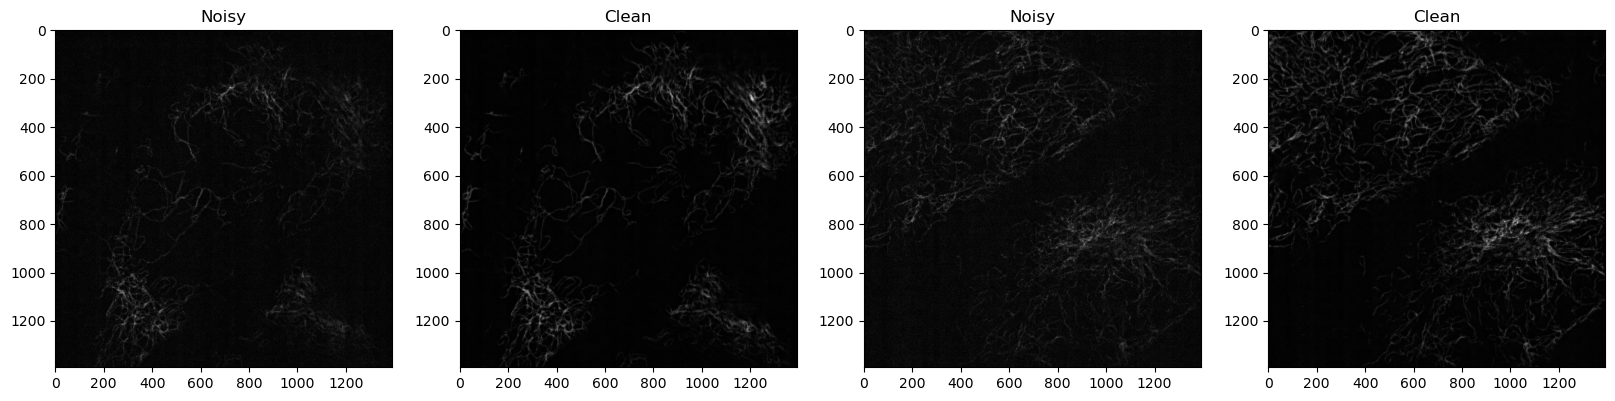

In [6]:
# Display examples

idxs = np.random.randint(0,observation.shape[0],2)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(observation[idxs[0]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,2)
plt.imshow(signal[idxs[0]],cmap="gray")
plt.title("Clean")

plt.subplot(1,4,3)
plt.imshow(observation[idxs[1]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,4)
plt.imshow(signal[idxs[1]],cmap="gray")
plt.title("Clean")

plt.show()

In [6]:
#patch size 64
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(64**2)*1)
patches = utils.extract_patches(observation, 64, num_patches)
patches.shape



100%|██████████| 25/25 [00:00<00:00, 140.68it/s]


(11825, 64, 64)

In [7]:
error_count=0
for i in range (patches.shape[0]):
    try:
        img_mmse, samples = boilerplate.predict(patches[i],1,model,None,device,tta)
    except:
        error_count+=1
print(f"#errors: {error_count}")

100%|██████████| 1/1 [00:00<00:00, 16.30it/s]

#errors: 0


In [7]:
#patch size 128
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(128**2)*1)
patches = utils.extract_patches(observation, 128, num_patches)
patches.shape


100%|██████████| 25/25 [00:00<00:00, 138.43it/s]


(2950, 128, 128)

In [8]:
error_count=0
for i in range (patches.shape[0]):
    try:
        img_mmse, samples = boilerplate.predict(patches[i],1,model,None,device,tta)
    except:
        error_count+=1
print(f"#errors: {error_count}")

100%|██████████| 1/1 [00:00<00:00, 26.82it/s]

#errors: 3


In [7]:
#patch size 256
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(256**2)*1)
patches = utils.extract_patches(observation, 256, num_patches)
patches.shape


100%|██████████| 25/25 [00:00<00:00, 139.65it/s]


(725, 256, 256)

In [8]:
error_count=0
for i in range (patches.shape[0]):
    try:
        img_mmse, samples = boilerplate.predict(patches[i],1,model,None,device,tta)
    except:
        error_count+=1
print(f"#errors: {error_count}")

100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

#errors: 101


In [ ]:
gaussian_noise_std = None
img_mmse_list = []
samples_list = []
# for i in range(observation.shape[0]):
for i in range (n_pred):
    # print(f"image {i}:",np.mean(observation[i]),np.std(observation[i]),np.max(observation[i]),np.min(observation[i]))
    
    # try:
        img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
        img_mmse_list.append(img_mmse)
        samples_list.append(np.stack(samples))
    # except:
    #     print(f"Error with image {i}")
        

In [ ]:
### saving solutions

for i in range(len(img_mmse_list)):
    summary = np.stack([signal[i],observation[i],img_mmse_list[i]])
    samples = samples_list[i]
    std = np.std(samples,axis=0)
    var = np.var(samples,axis=0)
    if save_mmse:
        imsave(save_folder / f"inp_gt_mmse{num_samples}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
    if save_samples:
        imsave(save_folder / f"samples_{i:02d}.tif",samples)
    if save_std:
        imsave(save_folder / f"var_{i:02d}.tif",std)
    if save_var:
        imsave(save_folder / f"var_{i:02d}.tif",var)